<a href="https://colab.research.google.com/github/metehangelgi/Customising-models-with-TensorFlow-2/blob/master/week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.2


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [ ]:
# Build the model

class MyModel(Model):

  def __init__(self) -> None:
      super(MyModel,self).__init__()
      self.dense_1 = Dense(64,activation='relu')
      self.dense_2 = Dense(10)
      self.dropout = Dropout(0.4)
    
  def call(self,inputs,training=True):
    x = self.dense_1(inputs)
    if training:
      x = self.dropout(x)
    return self.dense_2(x)

  


In [ ]:
class MyModel(Model):

  def __init__(self) -> None:
      super(MyModel,self).__init__()
      self.dense_1 = Dense(64,activation='relu')
      self.dense_2 = Dense(10)
      self.dense_3 = Dense(5)
      self.softmax = Softmax()
    
  def call(self,inputs):
    x = self.dense_1(inputs)
    y1 = self.dense_2(inputs)
    y2 = self.dense_3(y1)
    concat = concatenate([x,y2])
    return self.softmax(concat)

In [ ]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            multiple                  704       
                                                                 
 dense_14 (Dense)            multiple                  110       
                                                                 
 dense_15 (Dense)            multiple                  55        
                                                                 
 softmax_1 (Softmax)         multiple                  0         
                                                                 
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class MyCustomLayer(Layer):

    def __init__(self, input_dim, eps):
        super(MyCustomLayer, self).__init__()
        self.c = eps * tf.ones((input_dim,))

    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=0) + self.c

In [ ]:
layer = MyCustomLayer(3, 0.1)
x = tf.ones((2, 3))
print(layer(x).numpy())

[2.1 2.1 2.1]


#### Create custom layers

In [ ]:
# Create a custom layer

class MyCustomLayer(Layer):

    def __init__(self, units,input_dim):
        super(MyCustomLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim,units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


dense_layer = MyCustomLayer(3,5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[ 0.18364517  0.08020084 -0.07345802]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.06302956,  0.02473576, -0.06242047],
       [-0.0202798 ,  0.06948622, -0.05225272],
       [ 0.06694084,  0.00570662,  0.00709779],
       [ 0.05836075,  0.01097722, -0.00320997],
       [ 0.01559383, -0.03070498,  0.03732734]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [ ]:
# Specify trainable weights

class MyCustomLayerMean(Layer):

    def __init__(self, units,input_dim):
        super(MyCustomLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim,units),
                                 initializer='random_normal',trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


dense_layer = MyCustomLayerMean(3,5)

In [ ]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 1
non-trainable weights: 1


In [ ]:
# Create a custom layer to accumulate means of output values

class MyCustomLayerMean(Layer):

    def __init__(self, units,input_dim):
        super(MyCustomLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim,units),
                                 initializer='random_normal',trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                          trainable=False)
        self.number_call = tf.Variable(initial_value=0,
                                          trainable=False)

    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations,axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations,self.sum_activation/tf.cast(self.number_call,tf.float32)


dense_layer = MyCustomLayerMean(3,5)

In [ ]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.09631738  0.05971048  0.01527474]


In [ ]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs,rate=self.rate)

#### Implement the custom layers into a model

In [ ]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyCustomLayer(units_1,input_dim_1)
        self.dropout_1=MyDropout(0.5)
        self.layer_2 = MyCustomLayer(units_2,units_1)
        self.dropout_2=MyDropout(0.5)
        self.layer_3 = MyCustomLayer(units_3,units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [ ]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01029832 0.01345157 0.01288406 0.0371336  0.02134674 0.01151785
  0.03197777 0.05613982 0.01255021 0.00809189 0.01890863 0.05151242
  0.00777752 0.04502559 0.02502188 0.01186482 0.02706838 0.01328675
  0.01311611 0.01832021 0.03491406 0.03505437 0.02105129 0.05882832
  0.00209636 0.01951495 0.00910748 0.02020453 0.0088842  0.02636185
  0.01269222 0.03999658 0.01651155 0.01029755 0.01942688 0.01940679
  0.01834516 0.01436114 0.02151956 0.02604057 0.02961475 0.00892221
  0.0305973  0.01417349 0.01046635 0.02431638]], shape=(1, 46), dtype=float32)
Model: "my_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_custom_layer_9 (MyCustom  multiple                 640064    
 Layer)                                                          
                                                                 
 my_dropout_2 (MyDropout)    multiple                  0         
                 

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

x = tf.constant([-1, 0, 1], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.math.exp(x)
    z = 2 * tf.reduce_sum(y)
    dz_dx = tape.gradient(z, x)
dz_dx

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7357589, 2.       , 5.4365635], dtype=float32)>

#### Create synthetic data

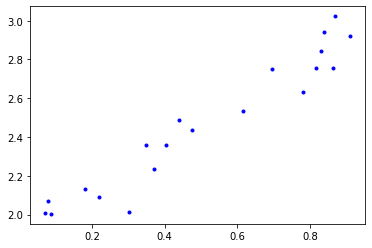

In [ ]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
# Build a custom layer for the linear regression model

class LineerLayer(Layer):
  def __init__(self):
    super(LineerLayer,self).__init__()
    self.m = self.add_weight(shape=(1,),
                             initializer='random_normal')
    self.b = self.add_weight(shape=(1,),
                             initializer='random_normal')
    
  def call(self,inputs):
    return self.m*inputs+self.b
  

linear_regression = LineerLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[-0.07113207 -0.07190005 -0.11188765 -0.09003721 -0.11227759 -0.08647102
 -0.0992355  -0.07154488 -0.10948616 -0.11019404 -0.09192386 -0.08824315
 -0.10329686 -0.11432215 -0.07679805 -0.10761653 -0.08303129 -0.085392
 -0.0786797  -0.11072386], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.05167601], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.06738173], dtype=float32)>]


#### Define the loss function

In [ ]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.6839743


#### Train and plot the model

In [ ]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions,y_train)

    gradients = tape.gradient(loss,linear_regression.trainable_variables)

    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])

    print('Step %d Loss %f' % (i,loss.numpy()))

Step 0 Loss 1.948193
Step 1 Loss 1.543435
Step 2 Loss 1.234732
Step 3 Loss 0.999115
Step 4 Loss 0.819108
Step 5 Loss 0.681416
Step 6 Loss 0.575926
Step 7 Loss 0.494944
Step 8 Loss 0.432614
Step 9 Loss 0.384485
Step 10 Loss 0.347168
Step 11 Loss 0.318086
Step 12 Loss 0.295278
Step 13 Loss 0.277251
Step 14 Loss 0.262871
Step 15 Loss 0.251273
Step 16 Loss 0.241802
Step 17 Loss 0.233956
Step 18 Loss 0.227355
Step 19 Loss 0.221709
Step 20 Loss 0.216799
Step 21 Loss 0.212456
Step 22 Loss 0.208553
Step 23 Loss 0.204992
Step 24 Loss 0.201699


m:1,  trained m:[2.592371]
b:2,  trained b:[1.0511782]


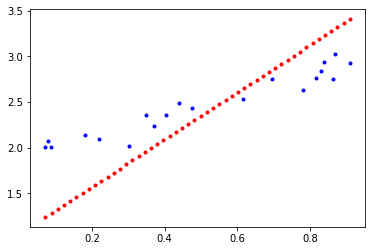

In [ ]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
# do no run 
import tensorflow as tf

for epoch in range(10):
	for inputs, outputs in training_dataset:
		with tf.GradientTape() as tape:
		    current_loss = loss(my_model(inputs), outputs)
		    grads = tape.gradient(current_loss, my_model.trainable_variables)
		optimizer.apply_gradients(zip(grads, my_model.trainable_variables))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [7]:
# Define the custom layers and model

class MyCustomLayer(Layer):

    def __init__(self, units):
        super(MyCustomLayer, self).__init__()
        self.units=units

    def build(self,input_shape):
        self.w = self.add_weight(shape=(input_shape[-1],self.units),
                                 initializer='random_normal',
                                 name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs,rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyCustomLayer(units_1)
        self.dropout_1=MyDropout(0.5)
        self.layer_2 = MyCustomLayer(units_2)
        self.dropout_2=MyDropout(0.5)
        self.layer_3 = MyCustomLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [8]:
# Instantiate a model object

model = MyModel(64,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.00997113 0.01642318 0.00978951 0.00345816 0.03897405 0.01937778
  0.01458077 0.00963377 0.00428758 0.01675624 0.03352214 0.00775902
  0.01482738 0.00767002 0.01869197 0.00981316 0.01943511 0.0102126
  0.01242421 0.03117278 0.00898227 0.0335019  0.01689306 0.0200165
  0.00656467 0.01429997 0.00506607 0.02005367 0.0270867  0.03204208
  0.01859619 0.03940649 0.00576322 0.02395533 0.01077744 0.01814349
  0.05525239 0.00348264 0.03152684 0.04165473 0.00935869 0.03066046
  0.03434687 0.13903846 0.01342564 0.03132365]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_custom_layer_3 (MyCustom  multiple                 640064    
 Layer)                                                          
                                                                 
 my_dropout_2 (MyDropout)    multiple                  0         
                    

#### Load the reuters dataset and define the class_names 

In [9]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2121728/2110848 [==============================] - 0s 0us/step


In [10]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [11]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

565248/550378 [==============================] - 0s 0us/step


In [12]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [13]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [14]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [15]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [21]:
# Implement the training loop
from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32)

# Keep result for plotting 
train_loss_results = []
trains_accuracy_results = []

num_epochs = 10 
weight_decay = 0.005

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  #Training loop 
  for x,y in train_dataset:
    loss_value , grads = grad(model,x,y,weight_decay)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

    # compute current loss
    epoch_loss_avg(loss_value)

    # compare predicted label to actual label
    epoch_accuracy(to_categorical(y),model(x))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  trains_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:03f}, Accuracy: {:.3%}".format(epoch,
                                                              epoch_loss_avg.result(),
                                                              epoch_accuracy.result()))

    
print("Duration :{:.3f}".format(time.time() - start_time))

Epcoh 000: Loss: 3.282414, Accuracy: 49.466%
Epcoh 001: Loss: 1.910908, Accuracy: 62.792%
Epcoh 002: Loss: 1.812217, Accuracy: 66.823%
Epcoh 003: Loss: 1.768328, Accuracy: 68.548%
Epcoh 004: Loss: 1.757940, Accuracy: 69.717%
Epcoh 005: Loss: 1.725726, Accuracy: 70.263%
Epcoh 006: Loss: 1.701359, Accuracy: 70.675%
Epcoh 007: Loss: 1.709436, Accuracy: 70.341%
Epcoh 008: Loss: 1.703006, Accuracy: 70.786%
Epcoh 009: Loss: 1.702446, Accuracy: 71.320%
Duration :113.668


#### Evaluate the model

In [22]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [23]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [24]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.845
Test accuracy: 67.186%


#### Plot the learning curves

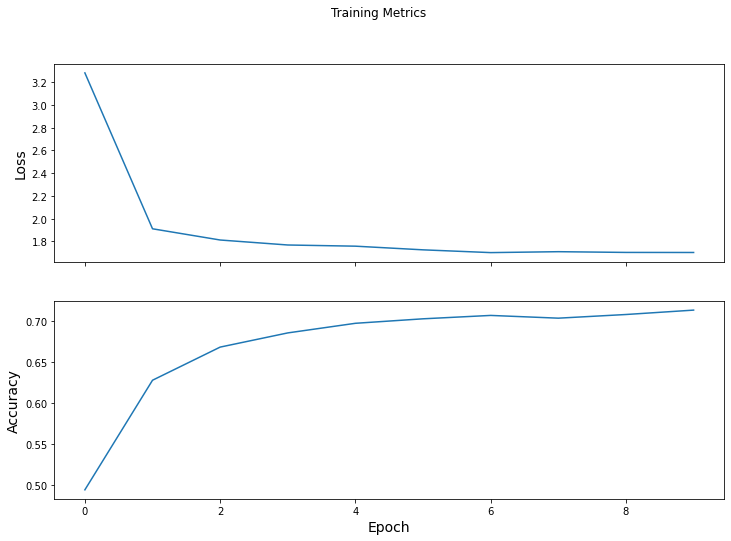

In [26]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(trains_accuracy_results)
plt.show()

#### Predict from the model

In [27]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [29]:
# Initialize a new model

model = MyModel(64,64,64)

#### Redefine the grad function using the @tf.function decorator

In [30]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [31]:
# Re-run the training loop

# Implement the training loop
from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32)

# Keep result for plotting 
train_loss_results = []
trains_accuracy_results = []

num_epochs = 10 
weight_decay = 0.005

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  #Training loop 
  for x,y in train_dataset:
    loss_value , grads = grad(model,x,y,weight_decay)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

    # compute current loss
    epoch_loss_avg(loss_value)

    # compare predicted label to actual label
    epoch_accuracy(to_categorical(y),model(x))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  trains_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:03f}, Accuracy: {:.3%}".format(epoch,
                                                              epoch_loss_avg.result(),
                                                              epoch_accuracy.result()))

    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 2.504828, Accuracy: 56.290%
Epoch 001: Loss: 1.982406, Accuracy: 64.318%
Epoch 002: Loss: 1.877764, Accuracy: 67.513%
Epoch 003: Loss: 1.821523, Accuracy: 68.214%
Epoch 004: Loss: 1.787583, Accuracy: 68.949%
Epoch 005: Loss: 1.756496, Accuracy: 69.606%
Epoch 006: Loss: 1.751658, Accuracy: 69.829%
Epoch 007: Loss: 1.738545, Accuracy: 70.530%
Epoch 008: Loss: 1.730566, Accuracy: 70.730%
Epoch 009: Loss: 1.703395, Accuracy: 70.330%
Duration :89.693


#### Print the autograph code

In [32]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

